In [1]:
%matplotlib inline
%autosave 60

import sys
sys.path.append('../boresightUtils/')
import matplotlib.pyplot as plt
import numpy as np
import random
import os

from boresightUtils import *
from scipy.optimize import differential_evolution
from scipy.ndimage import gaussian_filter
from scipy.stats import binned_statistic
from scipy.signal import fftconvolve

Autosaving every 60 seconds


In [2]:
# Instrument Specs
focalLengths = [135, 375, 750]
whDegs = [(7.91, 5.93), (2.85, 2.13), (1.42, 1.07)] # Image width and height in Degrees
plateScales = [8.64, 3.11, 1.56] # plate scales of cameras in arcsec / px
whPxs = [convert_fov_degs_px(whDeg, plateScale) for whDeg, plateScale in zip(whDegs, plateScales)]
thresholds = [0.3, 0.1, 0.1]
gSigs = [2, 4, 4]

# Notebook Configurables
camNum = 1 # Choose an instrument
figsDir = os.path.expanduser('~/Pictures/work/lsst/startracker/simulate_drift') # Where to save the figures
saveFig = True

# Parameters Derived / Selected from Configurables
focalLength = focalLengths[camNum]
plateScale = plateScales[camNum]
width, height = whPxs[camNum]
gaussianBlurSigma = gSigs[camNum]
threshold = thresholds[camNum]
xMu = width / 2 
yMu = height / 2

In [3]:
# Drift calibration
driftSpeedArcSec = 13 # arcseconds / s
driftDir = np.array([[1], [0]]) # Drifting right in px space initially
driftVel = driftSpeedArcSec / (plateScale) * driftDir # Drift in px / s
nStars = 25

ims = []
thetaInits = [0, 0]
driftTimes = [0, 180]

seed = 1000 # 98735927 # Set a seed (optional)

for i, (thetaInit, driftTime) in enumerate(zip(thetaInits, driftTimes)):
    # numpy random Stuff
    if seed is None:
        rng = np.random.default_rng() # Make one of these things
    else:
        rng = np.random.default_rng(seed)

    # Dictionary of Configurables to pass to functions
    configDict = {
        'expTime': 0,
        'slewRate': 6,
        'driftVel': driftVel,
        'threshold': threshold,
        'rng': rng,
        'imageWidth': width,
        'imageHeight': height,
        'gaussianBlurSigma': gaussianBlurSigma,
        'xMu': xMu,
        'yMu': yMu,
        'pointingSigma': 300,
        'nStars': nStars,
        }
    
    arcImg, pointingCenter = make_arc_image(configDict, thetaInit=thetaInit, driftTime=driftTime)
    ims.append(arcImg)

In [4]:
im0 = gaussian_blur_image(ims[0], configDict)
im1 = gaussian_blur_image(ims[1], configDict)

In [5]:
totalDrift = measure_drift(im0, im1)
driftRateRC = totalDrift / driftTimes[1]
driftRate = np.array([[driftRateRC[1]], [-driftRateRC[0]]])
print(driftRate)
print(driftVel)
print(driftRate - driftVel)

[[ 4.17777778]
 [-0.        ]]
[[4.18006431]
 [0.        ]]
[[-0.00228653]
 [-0.        ]]


In [6]:
pointingList = [(3*width/4, 3*height/4), (3*width/4, 1*height/4), (1*width/4, 1*height/4), (1*width/4, 3*height/4)]
nTrials = 10
biases = np.zeros((len(pointingList), nTrials, 2))

for iPointing, (xMu, yMu) in enumerate(pointingList):
    configDict = {
        'expTime': 15,
        'slewRate': 6,
        'driftVel': driftRate,
        'threshold': threshold,
        'rng': rng,
        'imageWidth': width,
        'imageHeight': height,
        'gaussianBlurSigma': gaussianBlurSigma,
        'xMu': xMu,
        'yMu': yMu,
        'pointingSigma': 0,
        'nStars': nStars,
        }

    biases[iPointing] = calculate_drift_bias(configDict, nTrials=nTrials)

In [7]:
print(biases)

[[[ 726.35220659 -663.87934163]
  [ -30.07787993  -26.76538913]
  [ -30.67795751  -28.20071287]
  [ -30.99401308  -24.8771512 ]
  [ -29.1091559   -29.78320938]
  [ -31.02676434  -29.90664269]
  [ 711.9917877  -746.31267337]
  [ -30.040032    -28.29618196]
  [ -32.74703489  -25.79401159]
  [ 296.34557991 -549.06707888]]

 [[ -33.07725484  -25.26253167]
  [ -31.45257497  -31.05577612]
  [ -31.57410214  -26.84918389]
  [ -32.53016444  -29.07249433]
  [ -32.37164601  -29.49567386]
  [ -32.1510674   -29.41728567]
  [ -31.80610916  -30.91455423]
  [ -32.2396294   -23.51131493]
  [ -32.27361519  -31.40346467]
  [ -32.6431741   -30.85071027]]

 [[ -31.61452661  -30.36010436]
  [ -31.10660161  -28.49735672]
  [ -32.34356014  -26.15258278]
  [ -33.11597036  -25.85002511]
  [ -26.35196365  -28.41888637]
  [ -31.51002012  -31.05762905]
  [ -30.75173246  -31.75003648]
  [ -32.35633159  -27.96952229]
  [ -31.80268893  -28.71982753]
  [ -31.83536007  -28.62727794]]

 [[ -31.44810087  -31.75929539]
  

In [27]:
arcImg, trueBoresight = make_arc_image(configDict, thetaInit=thetaInit, driftTime=driftTime)
# nTrials = 10
# boresights = np.zeros((nTrials, 2))

# for i in range(nTrials):
#     boresights[i] = find_boresight_naive(arcImg)

# boresight = boresights.mean(axis=0) - bias

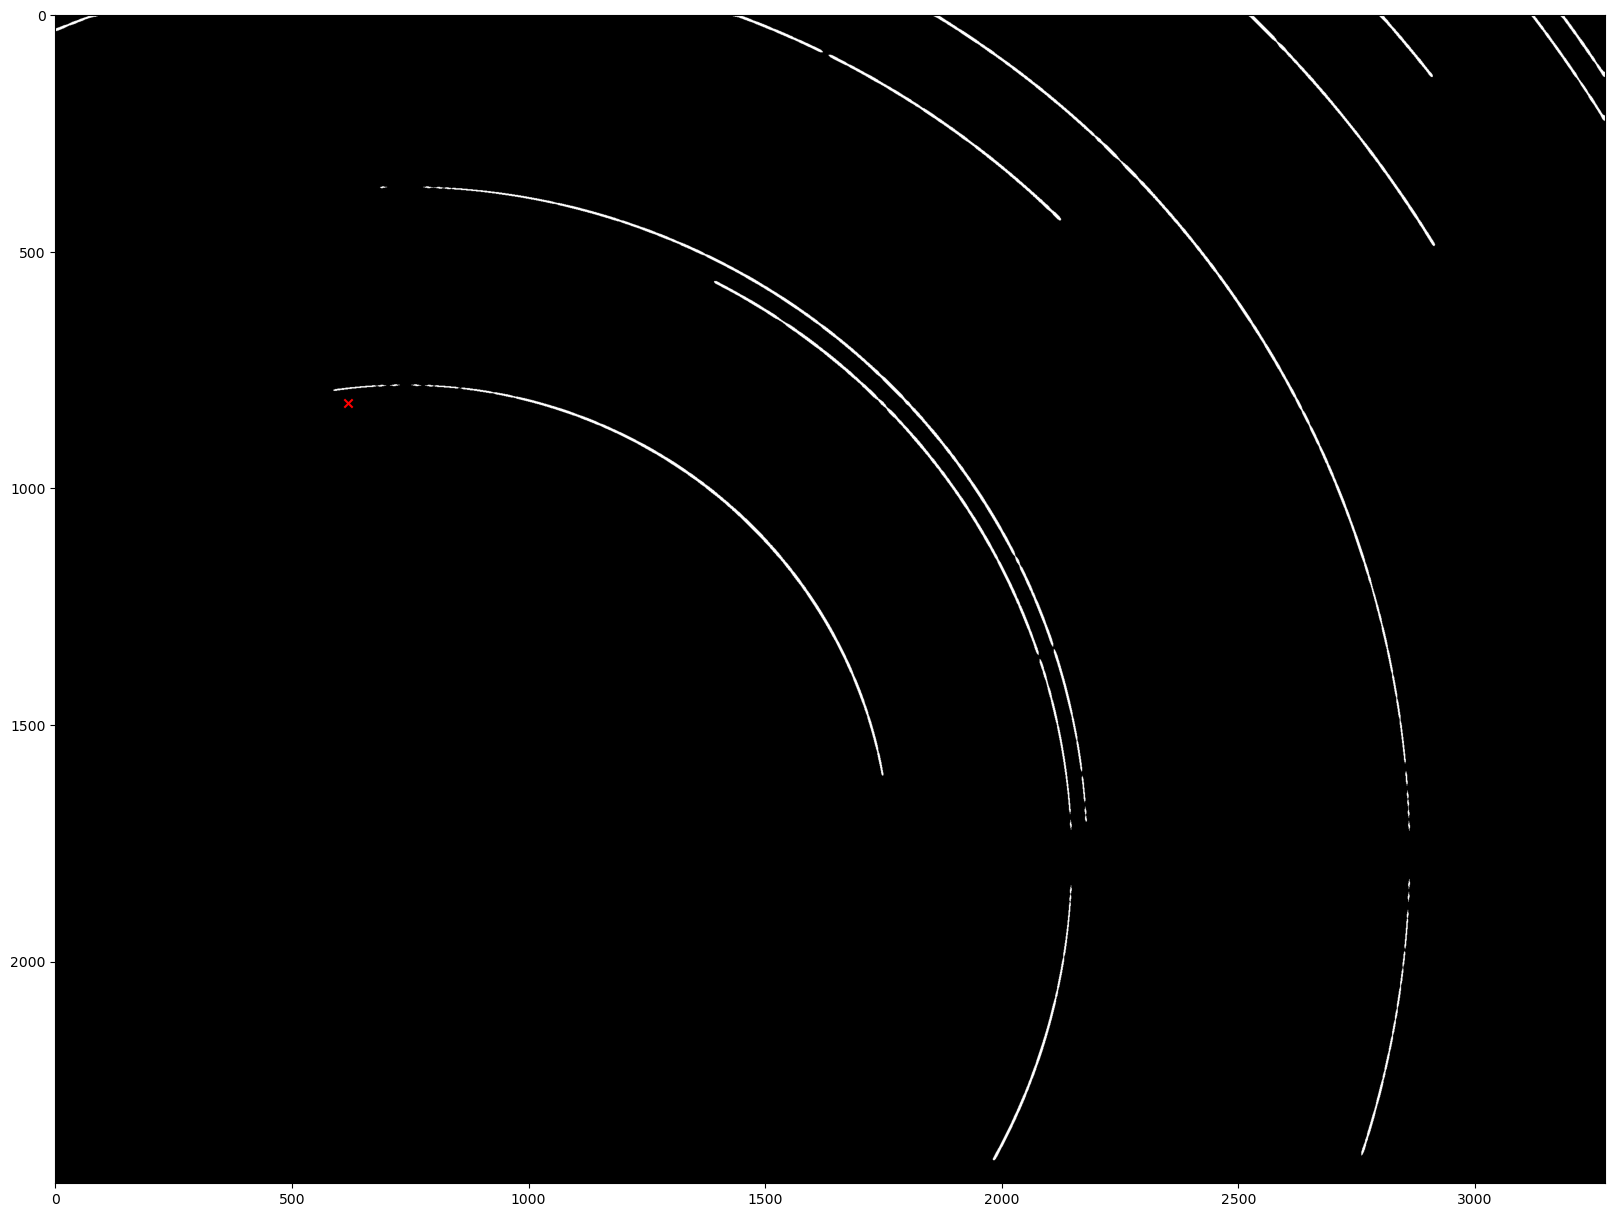

In [28]:
bpxs = make_threshold_image(arcImg, configDict)
plot_arc_image(bpxs, boresight=trueBoresight)

In [11]:
trueBoresightIdx = xy_image_coord_transform(trueBoresight, bpxs)
print(boresight, trueBoresightIdx, boresight - trueBoresightIdx)

[1231.20365637 2136.06952277] [1230.58861958 2136.73176742] [ 0.61503679 -0.66224464]
